## netCDF: Importing netCDF files, extracting desired data and bringing it into a desired format

In this file I will itterativly try to load and understand the structure of the by anemos delivered netCDF wind data.

1. I am going to install and load all the necessary packages to work with and analyse netCDF data

In [1]:
import xarray as xr
import timeit
import pandas as pd
import numpy as np
#import hvplot.xarray
import cartopy.crs as ccrs
import sys
def format_bytes(size):
    # 2**10 = 1024
    power = 2**10
    n = 0
    power_labels = {0 : '', 1: 'kilo', 2: 'mega', 3: 'giga', 4: 'tera'}
    while size > power:
        size /= power
        n += 1
    return size, power_labels[n]+'bytes'

import matplotlib.pyplot as plt

print(xr.__version__)

0.20.2


# Loading a netCDF file with the xarray package

In [ ]:
#path = r"windData/wdirC.7L.2017-T.ts.nc"
year = 2017
nc_data_path = f"/uba/anemos_winddata/20191029_anemosDataFull/UBA-Windatlas/NC-Format/wspd.10L.{year}.nc"
tsnc_data_path = f"/uba/anemos_winddata/20191029_anemosDataFull/UBA-Windatlas/TSNC-Format/wspd.10L.{year}.ts.nc"

start = timeit.default_timer()

data = xr.open_dataset(nc_data_path, chunks={'time': 100}, engine='h5netcdf')
# for multiple files
#data = xr.open_mfdataset(nc_data_path, chunks={'time': 100}, parallel=True, engine='h5netcdf')

stop = timeit.default_timer()

print(f'Loadingtme for netCDF-file: {stop - start}')
size = format_bytes(sys.getsizeof(data))
print(f"Size of loaded file: {size}")
data

## Replace `x,y` Dimensions 

Initially the `x,y` dimensions of the netCDF file where ranging from 0 to the number of raw or column. The grid is structured as a *lambert projection*, but the absolut values of `0,...` do not represent the correct coordinates. Therefore,  anemos send us the correct lambert projection coordinates, in order to assign them to the `x,y` dimensions. 

With the result we should be able to transform a `lon,lat` coordinate *(EPSG=4326)* to a lambert projection coordinate.

In [ ]:
# Load the new dimensional lambda coordinates
path = "xy_lamber_projection_values"

new_dim_coor = pd.read_csv(path)
new_dim_coor.head()

In [ ]:
# assign the new x,y values to the netCDF data
x = new_dim_coor["x"].dropna().astype("int").values
y = new_dim_coor["y"].values

data = data.assign_coords(
    coords={"x": x,"y": y}
)

### Using coordination transformation with projections to get exact `[x,y]` float equivalents to the multidimensional `[lon(x,y),lat(x,y)]`

#### *cartopy*: **NOT WORKING (same for anemos)**

In [ ]:
map_proj = ccrs.LambertConformal(
    central_longitude=data.CEN_LON[0], 
    central_latitude=data.CEN_LAT[0], 
    #false_easting=,
    #false_northing=,
    standard_parallels=(data.MOAD_CEN_LAT[0], data.STAND_LON[0]),
    #globe=None,
    #cutoff=-30
    )

x, y = map_proj.transform_point(47.2, 5.899, src_crs=ccrs.PlateCarree())
print(f"x:{x}, y:{y}")

#### *pyproj*: **WORKING (code and new `x,y` coordinates from anemos)**

In [ ]:
from pyproj import CRS, Transformer

crsD3E5 = CRS.from_proj4("+proj=lcc +lat_1=48.0 +lat_2=54.0 +lat_0=50.893 +lon_0=10.736 +a=6370000 +b=6370000 +nadgrids=null +no_defs")
crsGeo = CRS.from_epsg(4326)
geo2altas = Transformer.from_crs(crsGeo, crsD3E5)
lon = 10.0
lat = 50.0

#lon = point["coor"][1]
#lat = point["coor"][0]

x,y = geo2altas.transform(lat, lon)
print(f"x:{x}, y:{y}")
data.interp(x=x,y=y,level=110,time=f"{year}-03-29T19:30").load()

#### *gdal*: **WORKING (code and new `x,y` coordinates from anemos)**

In [ ]:
import ogr
import osr
d3e5Prj = osr.SpatialReference()
d3e5Prj.ImportFromProj4("+proj=lcc +lat_1=48.0 +lat_2=54.0 +lat_0=50.893 +lon_0=10.736 +a=6370000 +b=6370000 +nadgrids=null +no_defs")
geoPrj = osr.SpatialReference()
geoPrj.ImportFromEPSG(4326)
lon = 10.0
lat = 50.0

#lon = point["coor"][1]
#lat = point["coor"][0]

point = ogr.Geometry(ogr.wkbPoint)
point.AddPoint(lat, lon)
point.AssignSpatialReference(geoPrj)    # tell the point what coordinates it's in
point.TransformTo(d3e5Prj)              # project it to the out spatial reference
print(f'{point.GetX()},{point.GetY()}')
data.interp(x=point.GetX(),y=point.GetY(),level=110,time=f"{year}-03-29T19:30").load()

## Putting together a function to perform the coordinate transformation

In [2]:
def coor_transformation(coor:list,engine:str="pyproj")->list:
    lambert_proj_str = "+proj=lcc +lat_1=48.0 +lat_2=54.0 +lat_0=50.893 +lon_0=10.736 +a=6370000 +b=6370000 +nadgrids=null +no_defs"

    if engine == "pyproj":
        from pyproj import CRS, Transformer

        crsD3E5 = CRS.from_proj4(lambert_proj_str)
        crsGeo = CRS.from_epsg(4326)
        geo2altas = Transformer.from_crs(crsGeo, crsD3E5)

        x,y = geo2altas.transform(coor[0], coor[1])
        return[x,y]

    if engine == "gdal":
        import ogr
        import osr
        d3e5Prj = osr.SpatialReference()
        d3e5Prj.ImportFromProj4(lambert_proj_str)
        geoPrj = osr.SpatialReference()
        geoPrj.ImportFromEPSG(4326)

        point = ogr.Geometry(ogr.wkbPoint)
        point.AddPoint(coor[0], coor[1])
        point.AssignSpatialReference(geoPrj)    # tell the point what coordinates it's in
        point.TransformTo(d3e5Prj)              # project it to the out spatial reference
        return[point.GetX(),point.GetY()]

# Trying Coordinate Search

In [ ]:
ds = data.sel(level=120,time=f"{year}-03-29T19:30")
ds.wspd.plot(x='lon', y='lat', figsize=(13,13))
plt.scatter(ds.lon, ds.lat, s = 0.2)

In [ ]:
# A 2D plot of the SPEED variable, assigning the coordinate values,
# and plot the verticies of each point
dsplot = ds.where((lon-0.1 < data.lon) & (data.lon < lon+0.1) & (lat-0.1 < data.lat) & (data.lat < lat+0.1), drop=True)
dsplot.wspd.plot(x='lon', y='lat', figsize=(6,6))
plt.scatter(dsplot.lon, dsplot.lat)#, s = 0.2)

lon = 10.0
lat = 50.0

[x_interp,y_interp] = coor_transformation(coor=[lat,lon])
#print(x_interp,y_interp)

# Plot requested lat/lon point blue
plt.scatter(lon, lat, color='b')
plt.text(lon, lat, 'requested')

# Plot nearest point in the array red
ds_near = ds.interp(x=x_interp, y=y_interp, method="nearest")
plt.scatter(ds_near.lon, ds_near.lat, color='r')
plt.text(ds_near.lon, ds_near.lat, 'nearest')
#ds_near.load()

# Plot interpolation value
ds_interp = ds.interp(x=x_interp, y=y_interp, method="cubic")
plt.scatter(ds_interp.lon, ds_interp.lat, color='y', marker="x")
plt.text(ds_interp.lon, ds_interp.lat, 'interp')
ds_interp.load()

plt.title('speed at nearest interpolated point: %s' % ds_interp.wspd.data)

## Plotting time series

In [ ]:
# .nc data
year=2017

nc_data_path = f"/uba/anemos_winddata/20191029_anemosDataFull/UBA-Windatlas/NC-Format/wspd.10L.{year}.nc"

ncdata = xr.open_dataset(nc_data_path, chunks={'time': 1000}, engine='h5netcdf')

# Load the new dimensional lambda coordinates
path = "xy_lamber_projection_values"

new_dim_coor = pd.read_csv(path)

# assign the new x,y values to the netCDF data
x = new_dim_coor["x"].dropna().astype("int").values
y = new_dim_coor["y"].values

ncdata = ncdata.assign_coords(
    coords={"x": x,"y": y}
)

lon = 10.0
lat = 50.0

[x_interp,y_interp] = coor_transformation(coor=[lat,lon], engine="pyproj")

ts_interp = ncdata.interp(x=x_interp, y=y_interp, level=113, method="linear")
ts_interp#.wspd#.load().plot.line()

In [3]:
# .ts.nc data
#year=2017
#tsnc_data_path = f"/uba/transfer/UBA-Windatlas/TSNC-Format/wspd.10L.{year}.ts.nc"
mf_tsnc_data_path = "/uba/anemos_winddata/20191029_anemosDataFull/UBA-Windatlas/TSNC-Format/wspd.10L.*.ts.nc"

tsncdata = xr.open_mfdataset(mf_tsnc_data_path, chunks={'time': 1000}, engine='h5netcdf', parallel=True)

# Load the new dimensional lambda coordinates
path = "xy_lamber_projection_values"

new_dim_coor = pd.read_csv(path)

# assign the new x,y values to the netCDF data
x = new_dim_coor["x"].dropna().astype("int").values
y = new_dim_coor["y"].values

tsncdata = tsncdata.assign_coords(
    coords={"x": x,"y": y}
)

lon = 10.0
lat = 50.0

[x_interp,y_interp] = coor_transformation(coor=[lat,lon], engine="pyproj")

ts_interp = tsncdata.interp(x=x_interp, y=y_interp, level=113, method="linear")
ts_interp#.wspd#.plot.line(figsize=(13,5))

<xarray.Dataset>
Dimensions:  (time: 525888)
Coordinates:
    lat      float32 dask.array<chunksize=(), meta=np.ndarray>
    lon      float32 dask.array<chunksize=(), meta=np.ndarray>
  * time     (time) datetime64[ns] 2009-01-01 ... 2018-12-31T23:50:00
    x        float64 -5.253e+04
    y        float64 -9.889e+04
    level    int64 113
Data variables:
    wspd     (time) float32 dask.array<chunksize=(1000,), meta=np.ndarray>
Attributes: (12/130)
    TITLE:                           D3E5
    START_DATE:                      2003-12-27_00:00:00
    SIMULATION_START_DATE:           2003-12-01_00:00:00
    WEST-EAST_GRID_DIMENSION:        [256]
    SOUTH-NORTH_GRID_DIMENSION:      [352]
    BOTTOM-TOP_GRID_DIMENSION:       [50]
    ...                              ...
    ISOILWATER:                      [14]
    history:                         Wed Aug  7 19:02:24 2019: ncrcat -7 -L 3...
    NCO:                             4.4.2
    title:                           D3E5
    nco_openmp_thread_number:        [1]
    actual_range:                    [100. 100.]

In [26]:
path = "./temp/ts_temp.nc"
df2 = ts_interp.wspd.to_pandas()

In [25]:
df

,lat,lon,wspd,x,y,level
time,,,,,,
2009-01-01 00:00:00,49.999992,10.000001,1.183286,-52532.614068,-98889.175522,113
2009-01-01 00:10:00,49.999992,10.000001,1.211617,-52532.614068,-98889.175522,113
2009-01-01 00:20:00,49.999992,10.000001,1.262507,-52532.614068,-98889.175522,113
2009-01-01 00:30:00,49.999992,10.000001,1.317245,-52532.614068,-98889.175522,113
2009-01-01 00:40:00,49.999992,10.000001,1.368598,-52532.614068,-98889.175522,113
...,...,...,...,...,...,...
2018-12-31 23:10:00,49.999992,10.000001,5.067270,-52532.614068,-98889.175522,113
2018-12-31 23:20:00,49.999992,10.000001,4.907085,-52532.614068,-98889.175522,113
2018-12-31 23:30:00,49.999992,10.000001,4.954683,-52532.614068,-98889.175522,113


In [27]:
df2

time
2009-01-01 00:00:00    1.183286
2009-01-01 00:10:00    1.211617
2009-01-01 00:20:00    1.262507
2009-01-01 00:30:00    1.317245
2009-01-01 00:40:00    1.368598
                         ...   
2018-12-31 23:10:00    5.067270
2018-12-31 23:20:00    4.907085
2018-12-31 23:30:00    4.954683
2018-12-31 23:40:00    4.900857
2018-12-31 23:50:00    4.877074
Length: 525888, dtype: float64

<AxesSubplot:xlabel='time'>

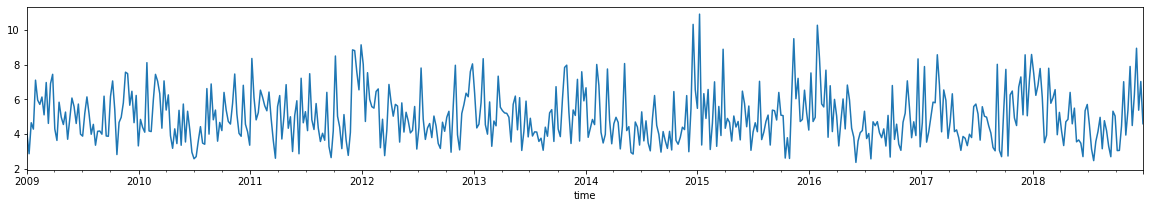

In [29]:
df2.resample('7d').median().plot(figsize=(20,3))

In [ ]:
test = xr.open_dataset(
    path,
    engine='h5netcdf'
)
test.wspd.plot.line()

# 2. yearly average data

The averaged data contains wind statistics of each coordinate at a certain level. In 12 directional subclases, both the average windspeed and the dominant wind direction is given.

In [ ]:
def circularHisto(xarray, dataVariable:str, grid=False):
    '''
    To Do's:
    - Add colorbar
    '''
    radii = xarray[dataVariable].values
    N = radii.size
    theta = np.linspace(0.0, 2 * np.pi, N, endpoint=False)
    width = np.full((1, 12), 2 * np.pi / 13)[0]
    
    ax = plt.subplot(111, projection='polar')
    bars = ax.bar(theta, radii, bottom=0.0, width=width)
    # Use custom colors and opacity
    for r, bar in zip(radii, bars):
        bar.set_facecolor(plt.cm.viridis(r / radii.max()))
        bar.set_alpha(0.7)

    ax.set_theta_zero_location("N")
    if grid:
        ax.set_rticks(np.arange(0,radii.max(),2))
    else:
        ax.set_rticks([])
    
    ticks = ["N","NW","W","SW","S","SE","E","NE"]
    ax.set_xticklabels(ticks)
    
    if dataVariable == "wspd":
        ax.set_title("Average Windspeed [m/s] 2008 - 2017", pad=25)
        
    if dataVariable == "histo":
        ax.set_title("Distribution of wind directions 2008 - 2017", pad=25)
    plt.show()
    
def describingHisto(xarray):
    fig, axs = plt.subplots(1, 2)
    
    diags =("histo","wspd")
    
    for num, ax in enumerate(axs):
        ax = circularHisto(xarray, dataVariable=diags[num])

In [ ]:
path = r"windData/D-3km.E5.dirStats.140m.2008-2017.nc"

data120m = xr.open_dataset(path)
data120m

In [ ]:
point = {
    "level":114,
    "y":0,
    "x":0,
    "coor":[50,10],
    "time":pd.to_datetime(["2016-05-01"])
}

start = timeit.default_timer()

([yloc], [xloc]), nlevel  = findPoint(data120m, point)

mid = timeit.default_timer()

point_stat = getPointData(xarray=data120m, x=xloc, y=yloc)

end = timeit.default_timer()

point["x"] = xloc
point["y"] = yloc

print(f'Nearest point: {point["x"]},{point["y"]}')
print(f'Nearest point coordinates: {point_stat.lon.values},{point_stat.lat.values}')
print(f'Time to find nearest point: {mid - start}')
print(f'Time to find get point data: {end - mid}')

point_stat

In [ ]:
circularHisto(point_stat, dataVariable="histo")
circularHisto(point_stat, dataVariable="wspd", grid=True)

In [ ]:
import numpy as np
import numba
from numba import cuda, f8, uint8

n = 20
dk = 0.00001

In [ ]:

def frange(n=n, dk =dk):
    dk = dk
    X = np.arange(dk, n, dk)
    outerSum = 0
    for i in range(X.shape[0]):
        k = X[i]
        outerSum += k

%timeit frange()


In [ ]:
@numba.jit(nopython=True)
def farange(n=n, dk =dk):
    dk = dk
    #X = np.arange(dk, n, dk)
    outerSum = 0
    for i in np.arange(dk, n, dk):
        outerSum += i

%timeit farange()

In [ ]:
@numba.jit(nopython=True)
def nbrange(n=n, dk =dk):
    dk = dk
    X = np.arange(dk, n, dk)
    outerSum = 0
    for i in range(X.shape[0]):
        k = X[i]
        outerSum += k

%timeit nbrange()

In [ ]:
@cuda.jit(argtypes=[f8, uint8])
def cudarange(n=n, dk =dk):
    dk = dk
    X = np.arange(dk, n, dk)
    outerSum = 0
    for i in range(X.shape[0]):
        k = X[i]
        outerSum += k

%timeit cudarange()